Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


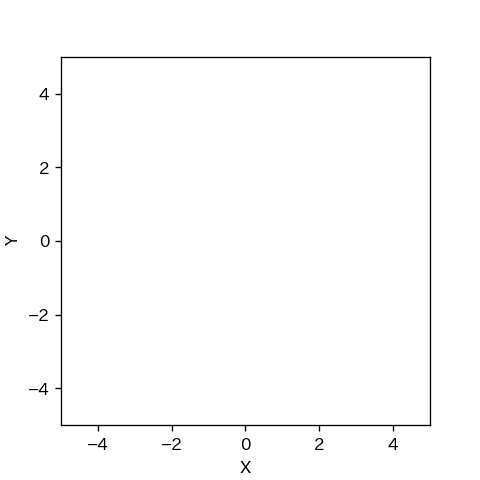

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
        
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-2,-2))
    m.append_landmark(Landmark(2,-2))
    m.append_landmark(Landmark(0,2*math.sqrt(3)-2))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose=np.array([np.random.uniform(-2.0,2.0),np.random.uniform(-2.0,2*math.sqrt(3)-2),np.random.uniform(-math.pi,math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


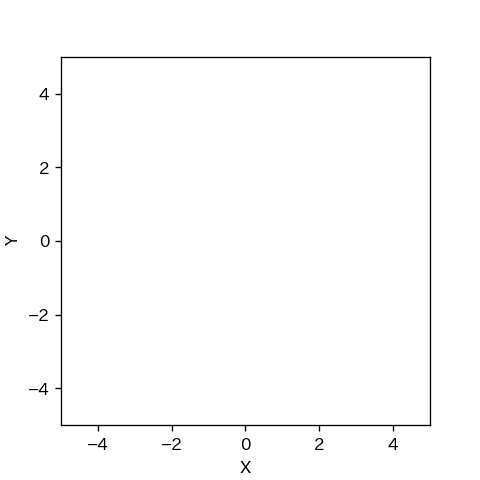

(array([0.98354432, 0.98884672, 1.48174548]),
 array([-0.57860858, -2.015709  ,  1.01506057]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

0 真値: [ 1.34176282 -0.35536692  1.96105997] 推定値: [ 1.45879311 -0.31437719  2.04650416] 誤差: 0.12400098988405749
1
1 真値: [-0.38935834 -1.40520895  6.52374908] 推定値: [-0.36574414 -1.36728927  0.32894834] 誤差: 0.044671380778575645
2
2 真値: [-0.71976285  0.78059564  5.52284978] 推定値: [-0.64081472  0.42339973  5.65422515] 誤差: 0.36581651629764983
3
3 真値: [1.96184916 0.65745838 3.30254546] 推定値: [1.96239161 0.64731739 3.31104461] 誤差: 0.010155486164563592
4
4 真値: [-0.82600049  0.62693023  3.8699292 ] 推定値: [-1.25030677  0.47600453  3.97932544] 誤差: 0.45034917534364144
5
5 真値: [-2.8807024  -1.4929025   5.95697406] 推定値: [-2.85991563 -1.49632022  5.98728289] 誤差: 0.021065867708088916
6
6 真値: [-0.51426659 -2.00083297  2.14444763] 推定値: [-0.23568244 -1.84188376  2.20510466] 誤差: 0.3207397415551812
7
7 真値: [1.0562877  2.27290941 3.31106829] 推定値: [1.03952828 2.07399031 3.24418905] 誤差: 0.1996238669122091
8
8 真値: [ 2.58681677 -1.58631766  1.59467575] 推定値: [-3.96504137 -0.62360077 -0.26143493] 誤差: 6.62221027549978

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [ 0.70487552 -0.74676628  7.47576053] 推定値: [ 1.20178723 -0.56861917  7.59749538] 誤差: 0.5278803235302457
18
21 真値: [ 0.66811572 -0.36145507  2.58650565] 推定値: [ 0.5958699  -0.37625376  2.53809888] 誤差: 0.07374590581772116
19
22 真値: [-0.0448341   0.283223    4.95711337] 推定値: [-0.00138364  0.26990579 -1.26149351] 誤差: 0.04544546748715314
20
23 真値: [-2.21508111 -1.68368965  5.81905595] 推定値: [-2.10133568 -1.75390676  5.8515974 ] 誤差: 0.13367298337412714
21
24 真値: [1.16727718 1.98374812 2.81297954] 推定値: [1.0665116  1.97107456 2.85328674] 誤差: 0.10155945502692064
22
25 真値: [1.11139773 0.58587611 6.30799869] 推定値: [0.79514854 0.90815413 0.19281358] 誤差: 0.45152703949808176
23
26 真値: [ 2.0540741  -0.93621964  3.68669486] 推定値: [ 2.14743358 -0.9823324   3.65428594] 誤差: 0.10412673911973869
24
27 真値: [-1.17434236 -1.38829484  7.05118559] 推定値: [-1.3273948  -1.42632769  0.79134723] 誤差: 0.15770715540796562
25
28 真値: [ 1.60994354 -0.35657218  3.95247415] 推定値: [ 1.22560294 -0.04364894 -2.17725928] 誤差: 0